In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style 

from tensorflow.keras.utils import plot_model
import random
from PIL import Image
import glob
import seaborn as sns
from tqdm.notebook import tqdm
import time

from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve,auc, accuracy_score, confusion_matrix, classification_report

import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [5]:
import seaborn as sns
sns.set(style='white')


In [7]:
train_path = "/Users/sunnygattu/Desktop/Education/Ml_final/dataset/Training"
test_path = "/Users/sunnygattu/Desktop/Education/Ml_final/dataset/Testing"

classes = ['no_tumor','pituitary_tumor', 'meningioma_tumor','glioma_tumor']


X_train = []
Y_train = []

def load_data(directory):
    for class_name in tqdm(os.listdir(directory),desc=directory):
        class_path = os.path.join(directory, class_name)
        class_label = class_name
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            img = cv2.imread(image_path)
            X_train.append(img)
            Y_train.append(classes.index(class_name))
    return X_train,Y_train
X_train , Y_train = load_data(train_path)
X_train , Y_train = load_data(test_path)

/Users/sunnygattu/Desktop/Education/Ml_final/dataset/Training:   0%|          | 0/4 [00:00<?, ?it/s]

/Users/sunnygattu/Desktop/Education/Ml_final/dataset/Testing:   0%|          | 0/4 [00:00<?, ?it/s]

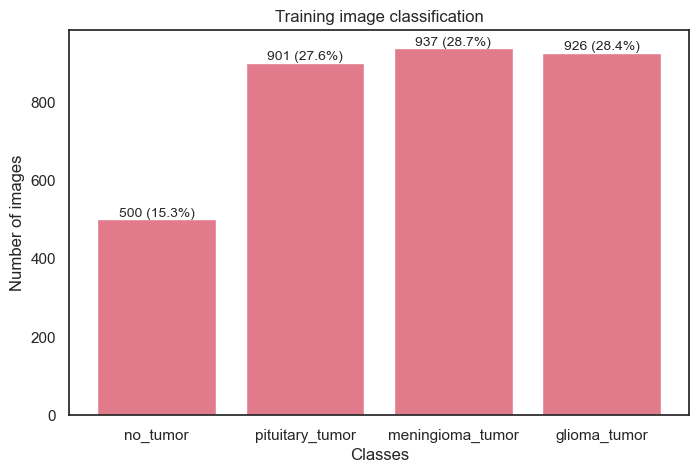

In [9]:
def count_images_per_class(data, classes):
    count_per_class = {class_name: 0 for class_name in classes}
    for class_idx in data:
        class_name = classes[class_idx]
        count_per_class[class_name] += 1
    return count_per_class

train_count_per_class = count_images_per_class(Y_train, classes)

plt.figure(figsize=(8, 5))

train_bars = plt.bar(train_count_per_class.keys(), train_count_per_class.values(), color='#E17A8A')
plt.title('Training image classification')
plt.xlabel('Classes')
plt.ylabel('Number of images')
# ajouter les pourcentages
for bar in train_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height} ({height / np.sum(list(train_count_per_class.values())) * 100:.1f}%)', ha='center', va='bottom', fontsize=10)

plt.show()

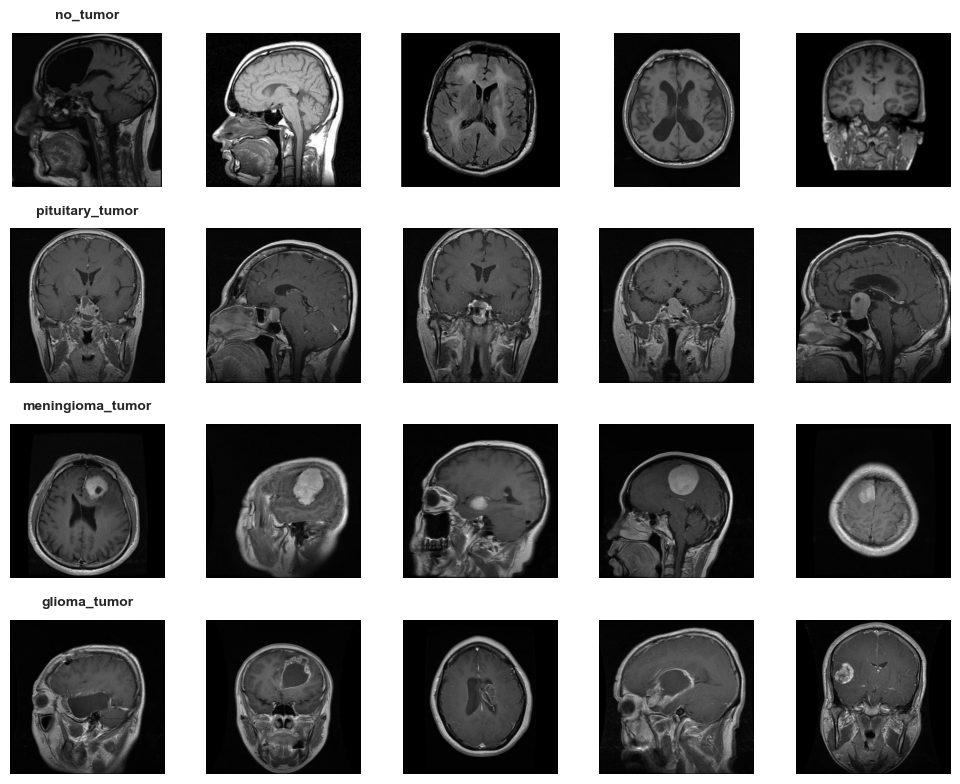

In [11]:
def show_examples(X_data, Y_data, classes, num_examples=5):
    num_classes = len(classes)
    fig, axs = plt.subplots(num_classes, num_examples, figsize=(10, 8))
    
    for i, class_name in enumerate(classes):
        class_indices = [idx for idx, label in enumerate(Y_data) if label == i]
        axs[i, 0].set_title(class_name, fontsize=10, pad=10, fontweight='bold')
        for j in range(num_examples):
                img = X_data[class_indices[j]]
                axs[i, j].imshow(img)
                axs[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

show_examples(X_train, Y_train, classes)

In [13]:
train_data_shapes = []
for img in X_train:
  train_data_shapes.append(img.shape)

shape_counts = {}
for shape in train_data_shapes:
  if shape not in shape_counts:
    shape_counts[shape] = 0
  shape_counts[shape] += 1

sorted_shapes = sorted(shape_counts.items(), key=lambda x: x[1], reverse=True)

print("Most frequent Train images shapes:")
for shape, count in sorted_shapes[:3]:
  print(f"- {shape}: {count}")

Most frequent Train images shapes:
- (512, 512, 3): 2341
- (236, 236, 3): 79
- (225, 225, 3): 43


In [15]:
shape = (225, 225, 3)

In [17]:
def crop_image(image):
    if len(image.shape) == 3:  
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:  
        gray = image.copy()

    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    largest_contour = max(contours, key=cv2.contourArea)

    cropped_image = image[cv2.boundingRect(largest_contour)[1]:cv2.boundingRect(largest_contour)[1] + cv2.boundingRect(largest_contour)[3], cv2.boundingRect(largest_contour)[0]:cv2.boundingRect(largest_contour)[0] + cv2.boundingRect(largest_contour)[2]]

    return cropped_image

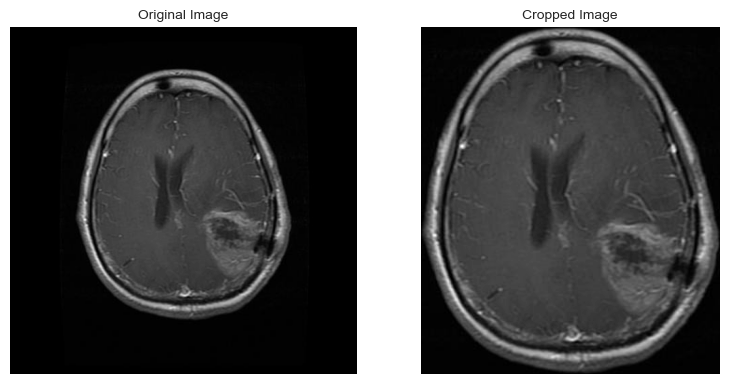

In [19]:
image_path = "/Users/sunnygattu/Desktop/Education/Ml_final/dataset/Testing/glioma_tumor/image(67).jpg"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

cropped_image = crop_image(img)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
plt.title("Original Image", fontsize=10)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cropped_image, cmap='gray')
plt.title("Cropped Image", fontsize=10)
plt.axis('off')

plt.tight_layout()
plt.show()

In [21]:
def preprocess_data(train_data):
  processed_data = []
  for img in tqdm(train_data):

    cropped_img = crop_image(img)

    resized_img = cv2.resize(cropped_img, (shape[1], shape[0]))

    normalized_img = cv2.normalize(resized_img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    processed_data.append(normalized_img)

  return processed_data

X_train = preprocess_data(X_train)

X_train = np.array(X_train)

  0%|          | 0/3264 [00:00<?, ?it/s]

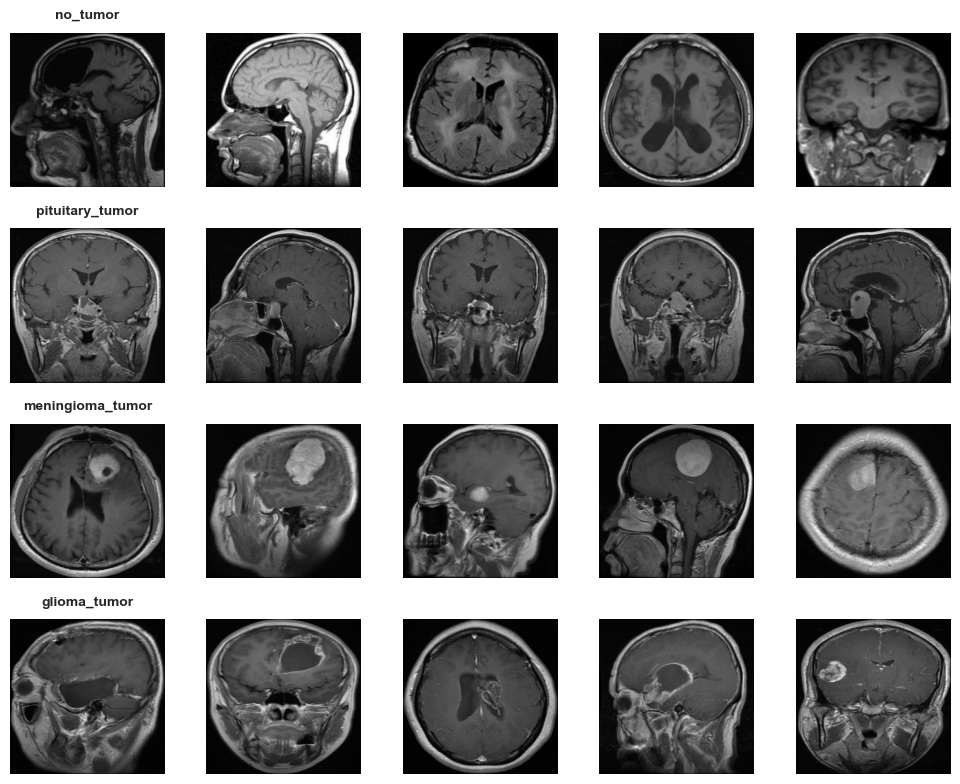

In [22]:
def show_examples(X_data, Y_data, classes, num_examples=5):
    num_classes = len(classes)
    fig, axs = plt.subplots(num_classes, num_examples, figsize=(10, 8))
    
    for i, class_name in enumerate(classes):
        class_indices = [idx for idx, label in enumerate(Y_data) if label == i]
        axs[i, 0].set_title(class_name, fontsize=10, pad=10, fontweight='bold')
        for j in range(num_examples):
                img = X_data[class_indices[j]]
                axs[i, j].imshow(img)
                axs[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

show_examples(X_train, Y_train, classes)

In [25]:
X_train, Y_train = shuffle(X_train,Y_train, random_state=64)

In [27]:
X_train,X_test,Y_train,Y_test = train_test_split(X_train,Y_train, test_size=0.3,random_state=64)

In [29]:
X_test,X_val,Y_test,Y_val = train_test_split(X_test,Y_test, test_size=2/3,random_state=64)

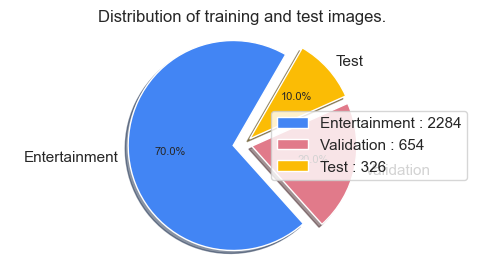

In [31]:
sizes = [len(Y_train), len(Y_val), len(Y_test)]
labels = ['Entertainment', 'Validation', 'Test']
colors = ['#4285f4', '#E17A8A', '#fbbc05']

plt.figure(figsize=(6,3))
plt.rcParams.update({'font.size': 8})
patches, texts, autotexts = plt.pie(sizes,labels=labels,colors=colors, autopct='%.1f%%', explode=(0.1,0.08,0.08), shadow=True, startangle=60);
plt.title(f"Distribution of training and test images.")
plt.legend(patches, [f"{label} : {size}" for label, size in zip(labels, sizes)], loc="best")
plt.axis('equal') 
plt.show()

In [33]:
Y_train =  np.array(tensorflow.keras.utils.to_categorical(Y_train))
Y_val =  np.array(tensorflow.keras.utils.to_categorical(Y_val))
Y_test =  np.array(tensorflow.keras.utils.to_categorical(Y_test))

In [35]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.,
    height_shift_range=0.,
    shear_range=0.2,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

In [37]:
train_generator = train_datagen.flow(
    x=np.array(X_train),  
    y=np.array(Y_train) 
)

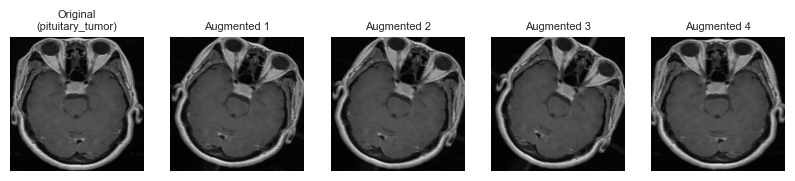

In [39]:
random_index = np.random.randint(len(X_train))
image = X_train[random_index]
class_label_encoded = Y_train[random_index]
class_label = classes[np.argmax(class_label_encoded)]

plt.figure(figsize=(10, 5))
plt.subplot(1, 5, 1)
plt.imshow(image)
plt.title('Original\n({})'.format(class_label), fontsize=8)
plt.axis('off')

for i in range(4):
    augmented_image = train_datagen.random_transform(image)
    plt.subplot(1, 5, i + 2)
    plt.imshow(augmented_image)
    plt.title('Augmented {}'.format(i + 1), fontsize=8)
    plt.axis('off')

plt.show()

In [41]:
CNN_model = Sequential()
CNN_model.add(Conv2D(16, (3,3), activation='relu', input_shape=shape))
CNN_model.add(MaxPooling2D(2,2))
CNN_model.add(Dropout(0.2))

CNN_model.add(Conv2D(32, (3,3), activation='relu'))
CNN_model.add(MaxPooling2D(2,2))
CNN_model.add(Dropout(0.2))

CNN_model.add(Conv2D(64, (3,3), activation='relu'))
CNN_model.add(MaxPooling2D(2,2))
CNN_model.add(Dropout(0.2))

CNN_model.add(Conv2D(128, (3,3), activation='relu'))
CNN_model.add(MaxPooling2D(2,2))
CNN_model.add(Dropout(0.2))

CNN_model.add(Conv2D(512, (3,3), activation='relu'))
CNN_model.add(MaxPooling2D(2,2))
CNN_model.add(Dropout(0.2))

CNN_model.add(Flatten())
CNN_model.add(Dense(512, activation='relu'))
CNN_model.add(Dropout(0.5))

CNN_model.add(Dense(len(classes), activation='softmax'))

CNN_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
CNN_model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 223, 223, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,243,940 (27.63 MB)

 Trainable params: 7,243,940 (27.63 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
tensorflow.keras.utils.plot_model(CNN_model,show_shapes=True, show_layer_names=True, dpi=50)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [47]:
batch_size = 64

image_shape = shape

epochs = 80

print(f'Batch size: {batch_size}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')

Batch size: 64
Image shape: (225, 225, 3)
Epochs: 80


In [49]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, min_delta=0.0001, verbose=1) 
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)  
checkpoint = ModelCheckpoint(filepath='best_CNNModel.keras', monitor='val_accuracy', save_best_only=True, verbose=1)  

In [51]:
start_time = time.time()
CNN_history = CNN_model.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    validation_data = (X_val, Y_val),
    callbacks=[reduce_lr, early_stop, checkpoint],
    verbose=1
)
end_time = time.time()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 993ms/step - accuracy: 0.2924 - loss: 1.4419 - precision: 0.2160 - recall: 0.0119
Epoch 1: val_accuracy improved from -inf to 0.28746, saving model to best_CNNModel.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.2924 - loss: 1.4412 - precision: 0.2161 - recall: 0.0117 - val_accuracy: 0.2875 - val_loss: 1.3693 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - accuracy: 0.3300 - loss: 1.2913 - precision: 0.3252 - recall: 0.0099
Epoch 2: val_accuracy did not improve from 0.28746
72/72 ━━━━━━━━━━━━━━━━━━━━ 68s 945ms/step - accuracy: 0.3305 - loss: 1.2908 - precision: 0.3271 - recall: 0.0100 - val_accuracy: 0.2875 - val_loss: 1.6960 - val_precision: 0.6140 - val_recall: 0.1070 - learning_rate: 0.0010
Epoch 3/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 882ms/step - accuracy: 0.4244 - loss: 1.1754 - precision: 0.5269 - recall: 0.1240
Epoch 3: val_accuracy improved from 0.

In [53]:
runtime = end_time - start_time

hours = int(runtime / 3600)
minutes = int((runtime % 3600) / 60)
seconds = int(runtime % 60)

print("Total runtime:", hours, "hours,", minutes, "minutes,", seconds, "seconds")

Total runtime: 1 hours, 7 minutes, 38 seconds


In [55]:
CNN_history.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])

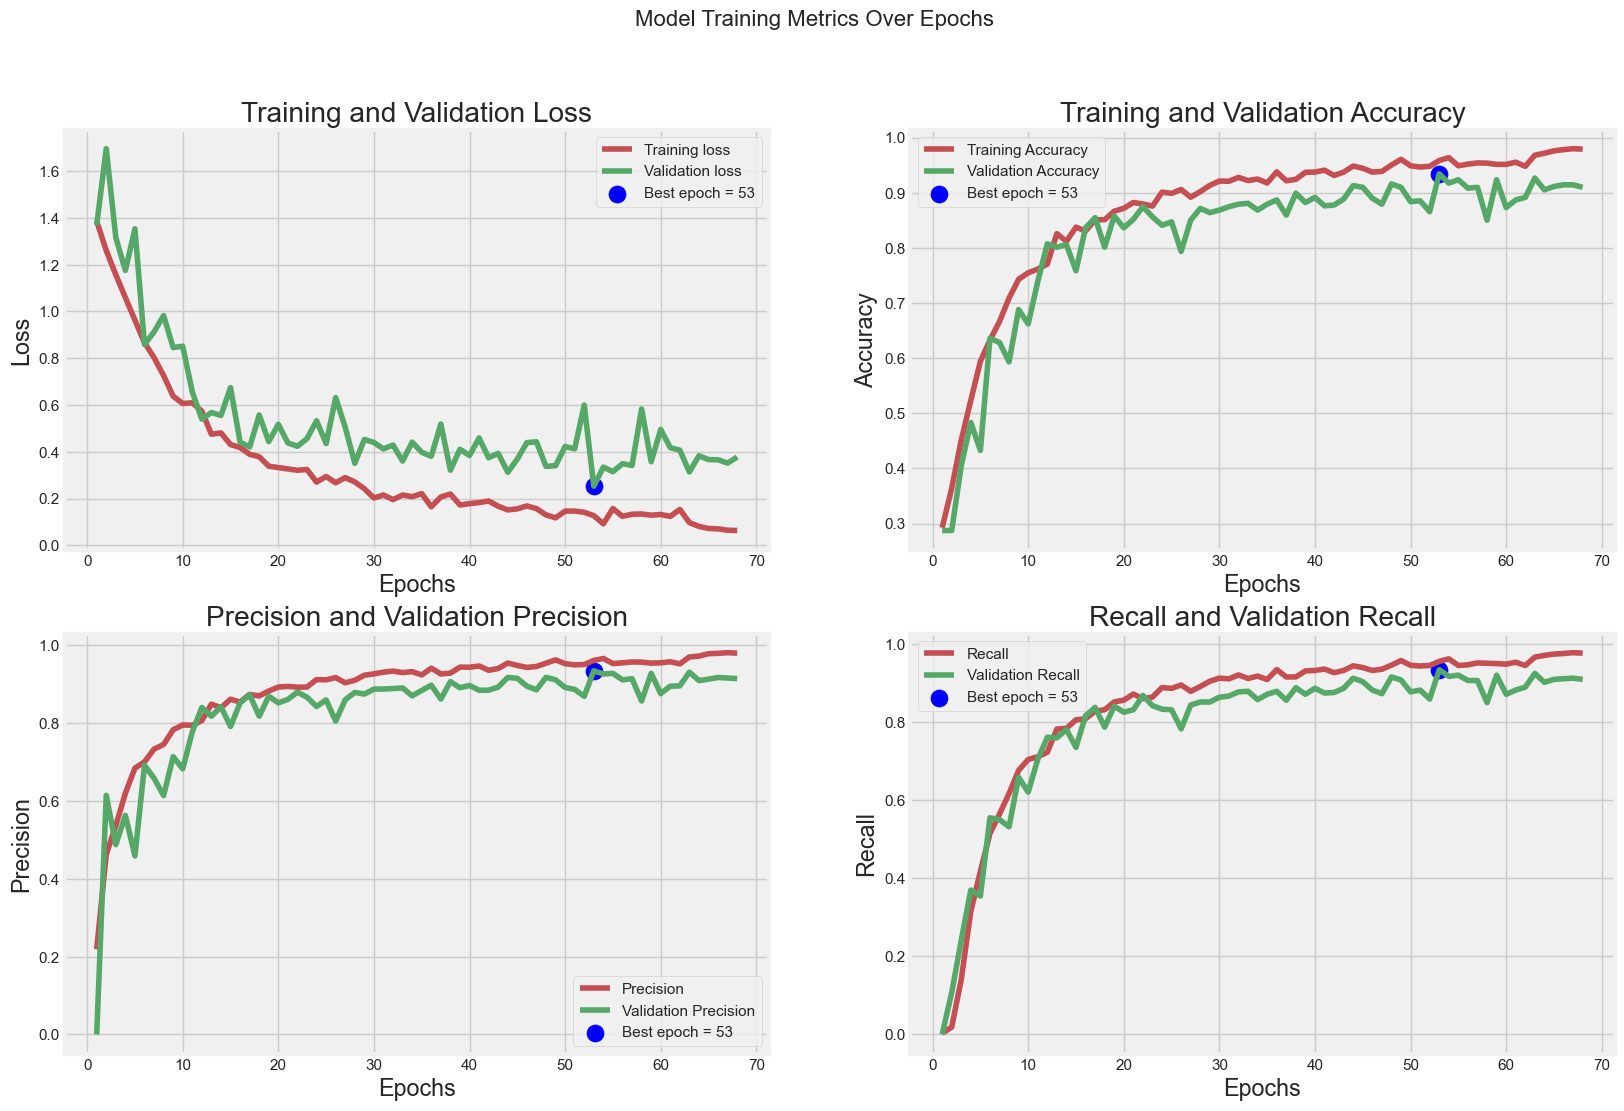

In [57]:
tr_acc = CNN_history.history['accuracy']
tr_loss = CNN_history.history['loss']
tr_per = CNN_history.history['precision']
tr_recall = CNN_history.history['recall']
val_acc = CNN_history.history['val_accuracy']
val_loss = CNN_history.history['val_loss']
val_per = CNN_history.history['val_precision']
val_recall = CNN_history.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [59]:
train_result = CNN_model.evaluate(X_train,Y_train)

print("Train Loss: {:.2f}%".format(train_result[0] * 100))
print("Train Accuracy: {:.2f}%".format(train_result[1] * 100))
print("Train Precision: {:.2f}%".format(train_result[2] * 100))
print("Train Recall: {:.2f}%".format(train_result[3] * 100))

72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - accuracy: 0.9943 - loss: 0.0284 - precision: 0.9949 - recall: 0.9943
Train Loss: 3.36%
Train Accuracy: 99.08%
Train Precision: 99.17%
Train Recall: 99.08%


In [61]:
test_results = CNN_model.evaluate(X_test,Y_test)

print("Test Loss: {:.2f}%".format(test_results[0] * 100))
print("Test Accuracy: {:.2f}%".format(test_results[1] * 100))
print("Test Precision: {:.2f}%".format(test_results[2] * 100))
print("Test Recall: {:.2f}%".format(test_results[3] * 100))

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.9137 - loss: 0.3094 - precision: 0.9232 - recall: 0.9137
Test Loss: 32.43%
Test Accuracy: 90.80%
Test Precision: 91.64%
Test Recall: 90.80%


In [63]:
predictions = CNN_model.predict(X_test)
y_true_test = np.argmax(Y_test, axis=1) 
y_pred_test = np.argmax(predictions, axis=1) 

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step


In [65]:
accuracy = accuracy_score(y_true_test, y_pred_test)
print("Accuracy:{:.2f}%".format(accuracy * 100))

Accuracy:90.80%


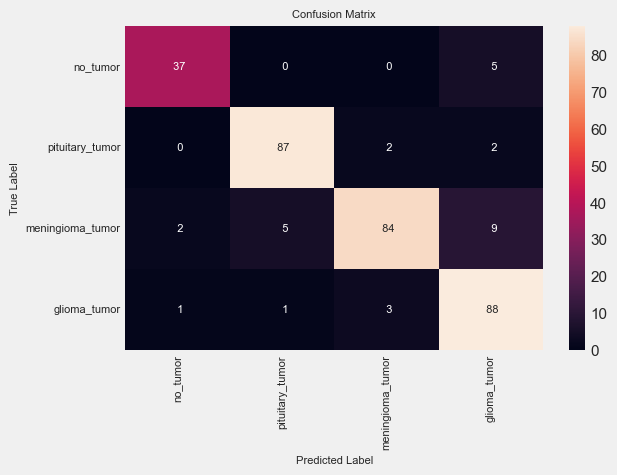

In [67]:
plt.figure(figsize=(6, 4))
heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='3g',
                      xticklabels=classes, yticklabels=classes, annot_kws={"size": 8})

plt.title('Confusion Matrix',fontsize=8)
plt.xlabel('Predicted Label',fontsize=8)
plt.ylabel('True Label',fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [69]:
class_report = classification_report(y_true_test, y_pred_test, target_names=classes)
print("Classification Report:")
print(class_report)

Classification Report:
                  precision    recall  f1-score   support

        no_tumor       0.93      0.88      0.90        42
 pituitary_tumor       0.94      0.96      0.95        91
meningioma_tumor       0.94      0.84      0.89       100
    glioma_tumor       0.85      0.95      0.89        93

        accuracy                           0.91       326
       macro avg       0.91      0.91      0.91       326
    weighted avg       0.91      0.91      0.91       326



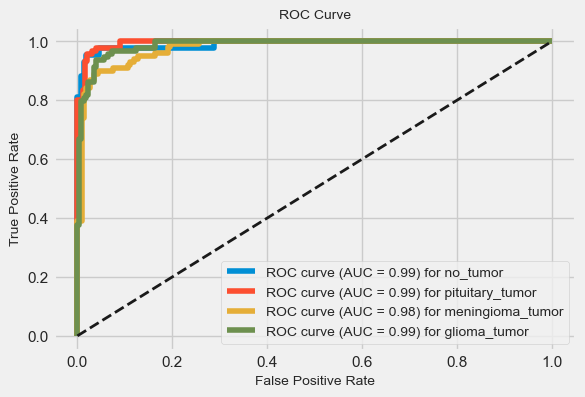

In [71]:
y_pred_prob = predictions
y_true_test_OneHot = np.array(tensorflow.keras.utils.to_categorical(y_true_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(6,4))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_true_test_OneHot[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f}) for {classes[i]}')

plt.plot([0, 1], [0, 1], 'k--', lw=2) 
plt.xlabel('False Positive Rate', fontsize=10)
plt.ylabel('True Positive Rate', fontsize=10)
plt.title('ROC Curve', fontsize=10)
plt.legend(loc='lower right', fontsize=10)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


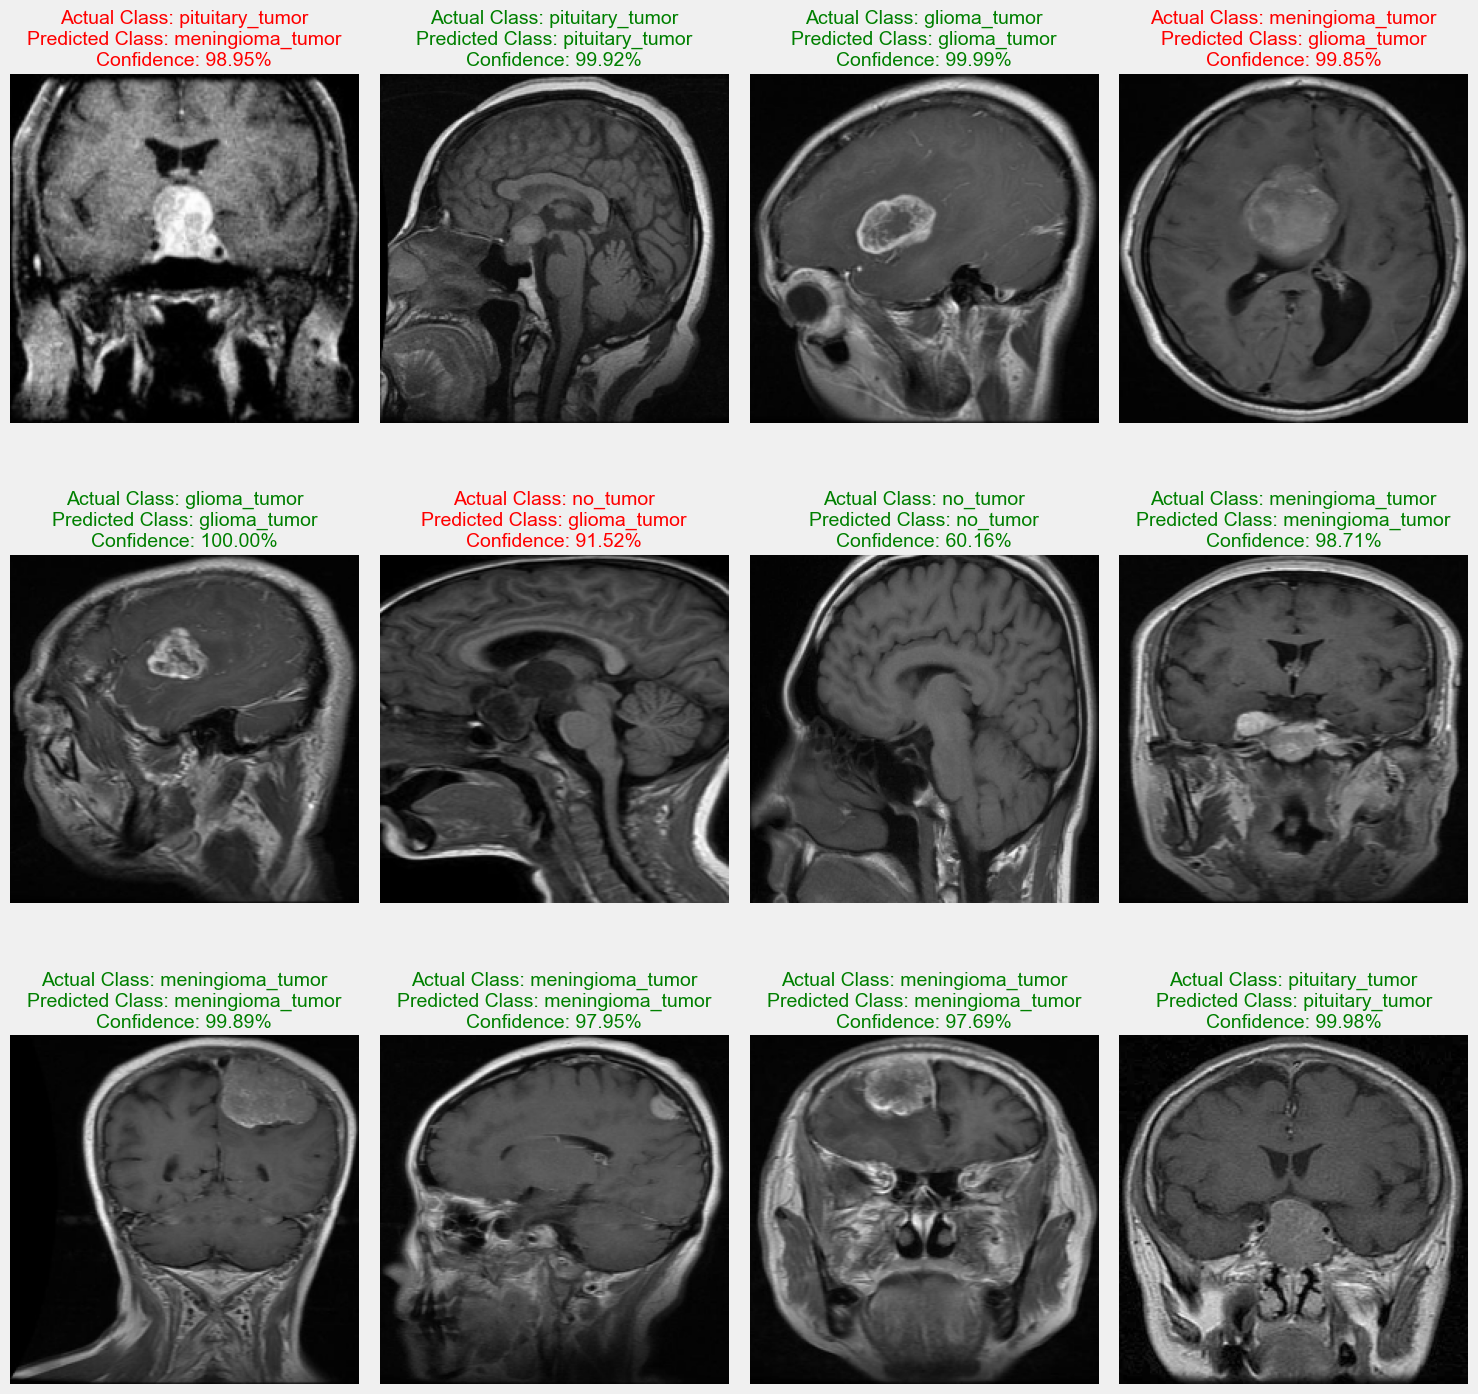

In [73]:
indices = np.random.choice(len(Y_test), size=12, replace=False)

images = X_test
Y_test = np.argmax(Y_test, axis=1)
labels = Y_test

plt.figure(figsize=(15, 15))

for i, idx in enumerate(indices):
    image = images[idx]
    true_label = classes[labels[idx]]

    prediction = CNN_model.predict(np.expand_dims(image, axis=0))
    predicted_class = classes[np.argmax(prediction)]
    confidence = np.max(prediction) * 100

    color = 'green' if true_label == predicted_class else 'red'

    plt.subplot(3, 4, i+1)
    plt.imshow(image)
    plt.title(f"Actual Class: {true_label}\nPredicted Class: {predicted_class}\nConfidence: {confidence:.2f}%", color=color, fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
y_test :  glioma_tumor
y_pred :  glioma_tumor


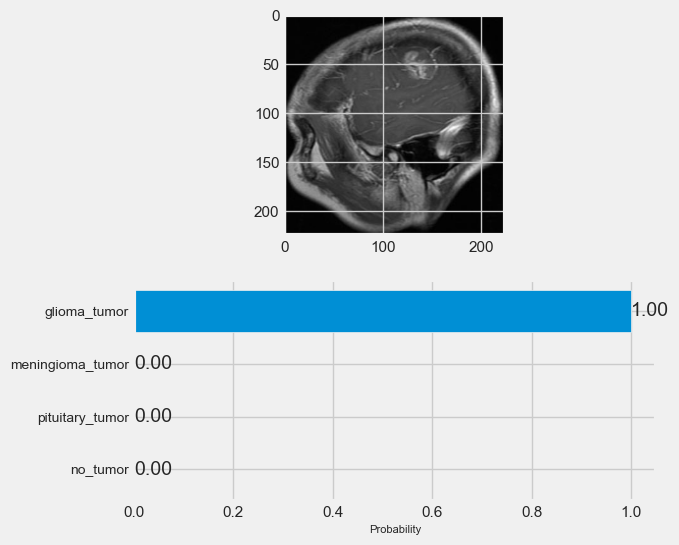

In [75]:
plt.figure(figsize=(6, 6))
resized_img = cv2.resize(X_test[1], (shape[1], shape[0]))
img = np.asarray(resized_img)
img = np.expand_dims(img, axis=0)
img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
predictions = CNN_model.predict(img)
print('y_test : ',classes[Y_test[1]])
y_pred = np.argmax(predictions, axis=1)
print('y_pred : ',classes[y_pred[0]])
probs = list(predictions[0])
labels = classes
plt.subplot(2, 1, 1)
plt.imshow(resized_img)
plt.subplot(2, 1, 2)
bars = plt.barh(labels, probs)
plt.xlabel('Probability', fontsize=8)
ax = plt.gca()
ax.bar_label(bars, fmt = '%.2f')
plt.yticks(fontsize=10) 
plt.show()